In [89]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

with open("sys",'r') as f:
    sys=f.read()

In [90]:
# 将设备按照latency从弱到强到强分为n个group
def staged(listTemp, n):
    listTemp = np.sort(listTemp)
    n = len(listTemp) // n + 1
    for i in range(0, len(listTemp), n):
        yield listTemp[i:i + n]

def cut(x,y,upper_bound_acc):
    threshold = 0
    delete_y = [t for t in y if t > upper_bound_acc]
    if len(delete_y) > 0:
        if isinstance(y, list):
            threshold = y.index(delete_y[0])
        else:
            threshold = y.tolist().index(delete_y[0])
    else:
        threshold = len(y)
    y = y[:threshold]
    x = x[:threshold]
    return x,y

def sum_duration_cached(m, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous=0, straggler=0, energy_sum = 0):
    client_num = 5
    comm_tmp = comm[m]
    duration = 0
    for i in range(0, idx - tmp):
        if heterogenous:
            l = random.choice(latency)
            if straggler: # Only work in heterogenous scenario
                for j in range(client_num - 1):
                    l = max(l,random.choice(latency)) 
            comp_tmp = l * batch_num / latency_tx2_cached[-1] * latency_tx2_cached[m]
        else:
            
            comp_tmp = latency_tx2_cached[m] * batch_num
            
        if energy_sum:
            duration = duration + comm_tmp
        else:
            duration = duration + comp_tmp + comm_tmp
    if len(time) > 0:
        time.append(duration + time[-1])
    else:
        time.append(duration)
    return time

def sum_duration(m, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous=0, straggler=0, energy_sum = 0):
    # m = depth
    client_num = 5
    comm_tmp = comm[m]
    duration = 0
    for i in range(0, idx - tmp):
        if heterogenous:
            l = random.choice(latency)
            if straggler: # Only work in heterogenous scenario
                for j in range(client_num - 1):
                    l = max(l,random.choice(latency)) 
            comp_tmp = l * batch_num / latency_tx2[-1] * latency_tx2[m]
        else:
            comp_tmp = latency_tx2[m] * batch_num
        if energy_sum:
            duration = duration + comm_tmp
        else:
            duration = duration + comp_tmp + comm_tmp
    if len(time) > 0:
        time.append(duration + time[-1])
    else:
        time.append(duration)
    return time
    
def insert_0(time, y):
    time.insert(0,0)
    # y = y.tolist()
    y.insert(0,0)
    return time, y

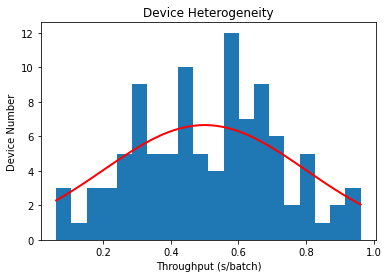

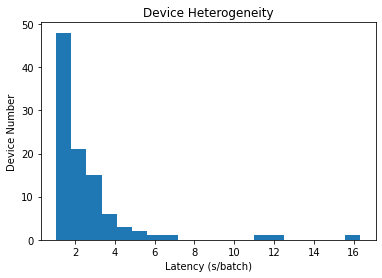

In [91]:
# strong device dominate
import matplotlib.pyplot as plt
import scipy.stats as stats

lower, upper = 1, 20
mu, sigma = 10, 6
num_bins = 20
device_number = 100
X = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
x = X.rvs(device_number)
s_fit = np.linspace(x.min(), x.max())


fig, ax = plt.subplots(1, sharex=True)
ax.hist(x/20, num_bins, density=0, stacked=0)
ax.plot(s_fit/20, stats.norm(mu, sigma).pdf(s_fit)*device_number, lw=2, c='r')
# ax.set_xlabel('Throughput (batch/s)')
ax.set_xlabel('Throughput (s/batch)')
ax.set_ylabel('Device Number')
# ax.set_title(r'Histogram of IQ: $\mu=10$, $\sigma=5$')
ax.set_title(r'Device Heterogeneity')

plt.savefig('device_distribution_100.pdf', bbox_inches="tight")

throughput = x / 20
latency = 1 / throughput
fig, ax = plt.subplots(1, sharex=True)
ax.hist(latency, num_bins, density=0, stacked=0)
ax.set_xlabel('Latency (s/batch)')
ax.set_ylabel('Device Number')
# ax.set_title(r'Histogram of IQ: $\mu=10$, $\sigma=5$')
ax.set_title(r'Device Heterogeneity')
plt.savefig('device_distribution_latency_weak.pdf', bbox_inches="tight")
latency = np.sort(latency)
latency_stage = list(staged(latency,3))

In [92]:
depth = np.array(range(0,13))
width = np.array([8,32,64,96,128,192])
method = np.array(["depth-0", "depth-1", "depth-2", "depth-3", "depth-4", "depth-5", "depth-6", "depth-7", "depth-8", "depth-9", "depth-10", "depth-11", "depth-12"])

model_size_8 = np.array([0.02 + i*0.01 for i in range(0,13)]) * 4
model_size_32 = np.array([0.02 + i*0.05 for i in range(0,13)]) * 4
model_size_96 = np.array([0.02 + i*0.15 for i in range(0,13)]) * 4
model_size_192 = np.array([0.02 + i*0.30 for i in range(0,13)]) * 4

# Width = 48
# model_size = np.array([0.02, 0.07, 0.12, 0.17, 0.22, 59.2, 30.8, 2.4,
#                 1.8, 1.8, 1.52, 1.2, 0.92, 0.64, 0.32, 0.04]) 

latency_tx2 = np.array([0.57, 0.57, 0.63, 0.66, 0.71, 0.75, 0.79, 0.84, 0.89, 0.94, 0.99, 1.03, 1.08])

# latency_rpi = np.array([18.27, 17.03, 15.03, 13.12, 11.83, 9.63, 8.02, 5.28,
#                 12.01, 11.65, 10.78, 9.87, 8.76, 7.85, 6.98, 7.05])

latency_tx2_cached = np.array([0.02, 0.09, 0.18, 0.27, 0.36, 0.45, 0.54, 0.63, 0.72, 0.81, 0.90, 0.99, 1.08])
# latency_rpi_cached = np.array([18.27, 16.28, 14.2, 10.89, 8.04, 5.7, 2.88, 0.14,
#                         11.25, 10.94, 9.92, 7.9, 5.96, 4.27, 2.14, 0.15])


bw = 1 # both for upload and download bandwidth
batch_num = 29 # per round
multiple = 10
# overhead per round
comm = model_size_32 * 2 / bw
comp = latency_tx2_cached * batch_num

# color for lines
color = ['darkred','darkblue','darkgreen','darkorange','darkviolet']
linestyle = [(0, ()), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4))]
lw = 8

In [93]:
def down_sample(x, mul = 5):
    # print(len(x))
    if isinstance(x, list):
        x = np.array(x)
    x = [x[i] for i in range(len(x)) if i % mul == 0]
    # print(len(x))
    return x

Depth-3-Width-16 - Evaluation Accuracy 23.608888888888668
Depth-3-Width-32 - Evaluation Accuracy 25.73505555555564
Depth-2-Width-8 - Evaluation Accuracy 4.928999999999971
Depth-0-Width-8 - Evaluation Accuracy 0.896222222222229
Depth-1-Width-8 - Evaluation Accuracy 3.4998055555555765


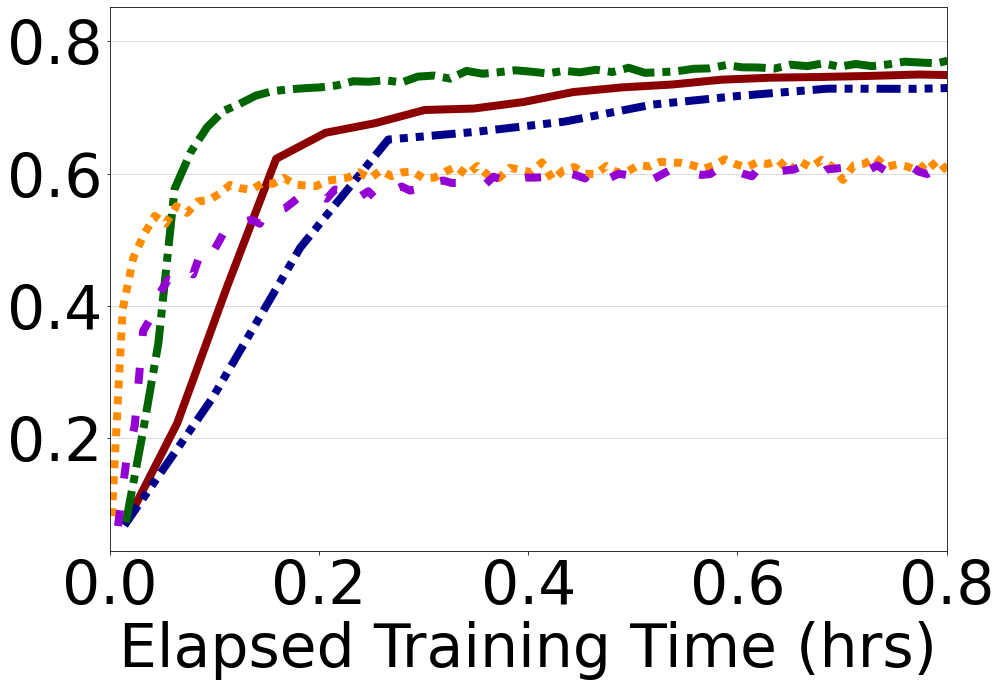

In [101]:
# variable adapter figuration
l = latency_tx2_cached
heterogenous = 0
straggler = 0
max_acc = 0.8
target_acc = 1
max_acc = max_acc * target_acc

plt.figure(figsize=(15,10))
# plt.title("Text Classification (20news)",fontsize=60)
# 设置刻度字体大小
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.xlabel("Elapsed Training Time (hrs)", fontsize=60)
# plt.ylabel("Accuracy", fontsize=60)
plt.xlim(0,0.8)
plt.grid(color = 'k', axis="y", linestyle = '--', linewidth = 0.5, alpha=0.4)

x_major_locator=MultipleLocator(0.2)
y_major_locator=MultipleLocator(0.2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

depth = np.array(range(0,13))
width = np.array([8,32,64,96,128,192])
method = np.array(["depth-0", "depth-1", "depth-2", "depth-3", "depth-4", "depth-5", "depth-6", "depth-7", "depth-8", "depth-9", "depth-10", "depth-11", "depth-12"])

model_size_8 = np.array([0.02 + i*0.01 for i in range(0,13)]) * 4
model_size_32 = np.array([0.02 + i*0.05 for i in range(0,13)]) * 4
model_size_96 = np.array([0.02 + i*0.15 for i in range(0,13)]) * 4
model_size_192 = np.array([0.02 + i*0.30 for i in range(0,13)]) * 4

# Width = 48
# model_size = np.array([0.02, 0.07, 0.12, 0.17, 0.22, 59.2, 30.8, 2.4,
#                 1.8, 1.8, 1.52, 1.2, 0.92, 0.64, 0.32, 0.04]) 

latency_tx2 = np.array([0.57, 0.57, 0.63, 0.66, 0.71, 0.75, 0.79, 0.84, 0.89, 0.94, 0.99, 1.03, 1.08])

# latency_rpi = np.array([18.27, 17.03, 15.03, 13.12, 11.83, 9.63, 8.02, 5.28,
#                 12.01, 11.65, 10.78, 9.87, 8.76, 7.85, 6.98, 7.05])

latency_tx2_cached = np.array([0.02, 0.09, 0.18, 0.27, 0.36, 0.45, 0.54, 0.63, 0.72, 0.81, 0.90, 0.99, 1.08])
# latency_rpi_cached = np.array([18.27, 16.28, 14.2, 10.89, 8.04, 5.7, 2.88, 0.14,
#                         11.25, 10.94, 9.92, 7.9, 5.96, 4.27, 2.14, 0.15])


bw = 1 # both for upload and download bandwidth
batch_num = 29 # per round
multiple = 10
# overhead per round
comm = model_size_32 * 2 / bw
comp = latency_tx2_cached * batch_num


data_path = "/Users/cdq/Desktop/opensource/FedFinetuning/data/Baseline/20news.csv"
# data_path = "/Users/cdq/Desktop/EuroSys23 files/Temp_Code/results/20news_bert_w_16.csv"
raw_data = pd.read_csv(data_path,index_col=0)
column_name = raw_data.columns.values
i = 0
for col in column_name:

   
    multiple = 10
    w = int(col.split("-")[3])
    # w = 32
    adapter_para = 0.0125 * w / 8
    model_size = np.array([0.02 + i * adapter_para for i in range(0,13)]) * 4
    comm = model_size * 2 / bw

    time = []
    d = int(col.split("-")[1])
    if d == 3 and w == 32:
        d = 10
        pass
    elif d == 2 and w == 8:
        pass
    elif d == 3 and w == 16:
        d = 6
    elif d == 1 and w == 8:
        pass
    elif d == 0 and w == 8:
        pass
    else:
        continue

    data = raw_data.iloc[:,column_name.tolist().index(col)].dropna()
    round_idx = np.array(list(range(0,len(data)))) * multiple
    tmp = -1 * multiple # 记录最后一个访问的idx
    for idx in round_idx:
        time = sum_duration_cached(d, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
        tmp = idx
    if i == 3:
        time = down_sample(time)
        data = down_sample(data)
    if i==0:
        time = np.array(time)
        time = time-0.03*3600
    if i==1:
        time = np.array(time)
        time = time-0.07*3600
    # time, data = cut(time, data, max_acc)
    plt.plot(np.array(time)/3600, data, label = "(" + str(d) + ", " + str(w) + ")",linewidth = lw,linestyle = linestyle[i],color=color[i])
    print(col,time[-1] / 3600)
    i = i + 1

# plt.legend(fontsize=40,ncol = 5,frameon=False,loc="lower left", bbox_to_anchor=(0.1, 1))
plt.savefig('../figs/design-configuration-20news.pdf', bbox_inches="tight")

Depth-6-Width-16 - Evaluation Accuracy 3.18033333333335
Depth-10-Width-8 - Evaluation Accuracy 5.864388888888875
Depth-2-Width-8 - Evaluation Accuracy 1.3159999999999994
Depth-0-Width-8 - Evaluation Accuracy 0.3834999999999983
Depth-1-Width-8 - Evaluation Accuracy 1.047249999999991


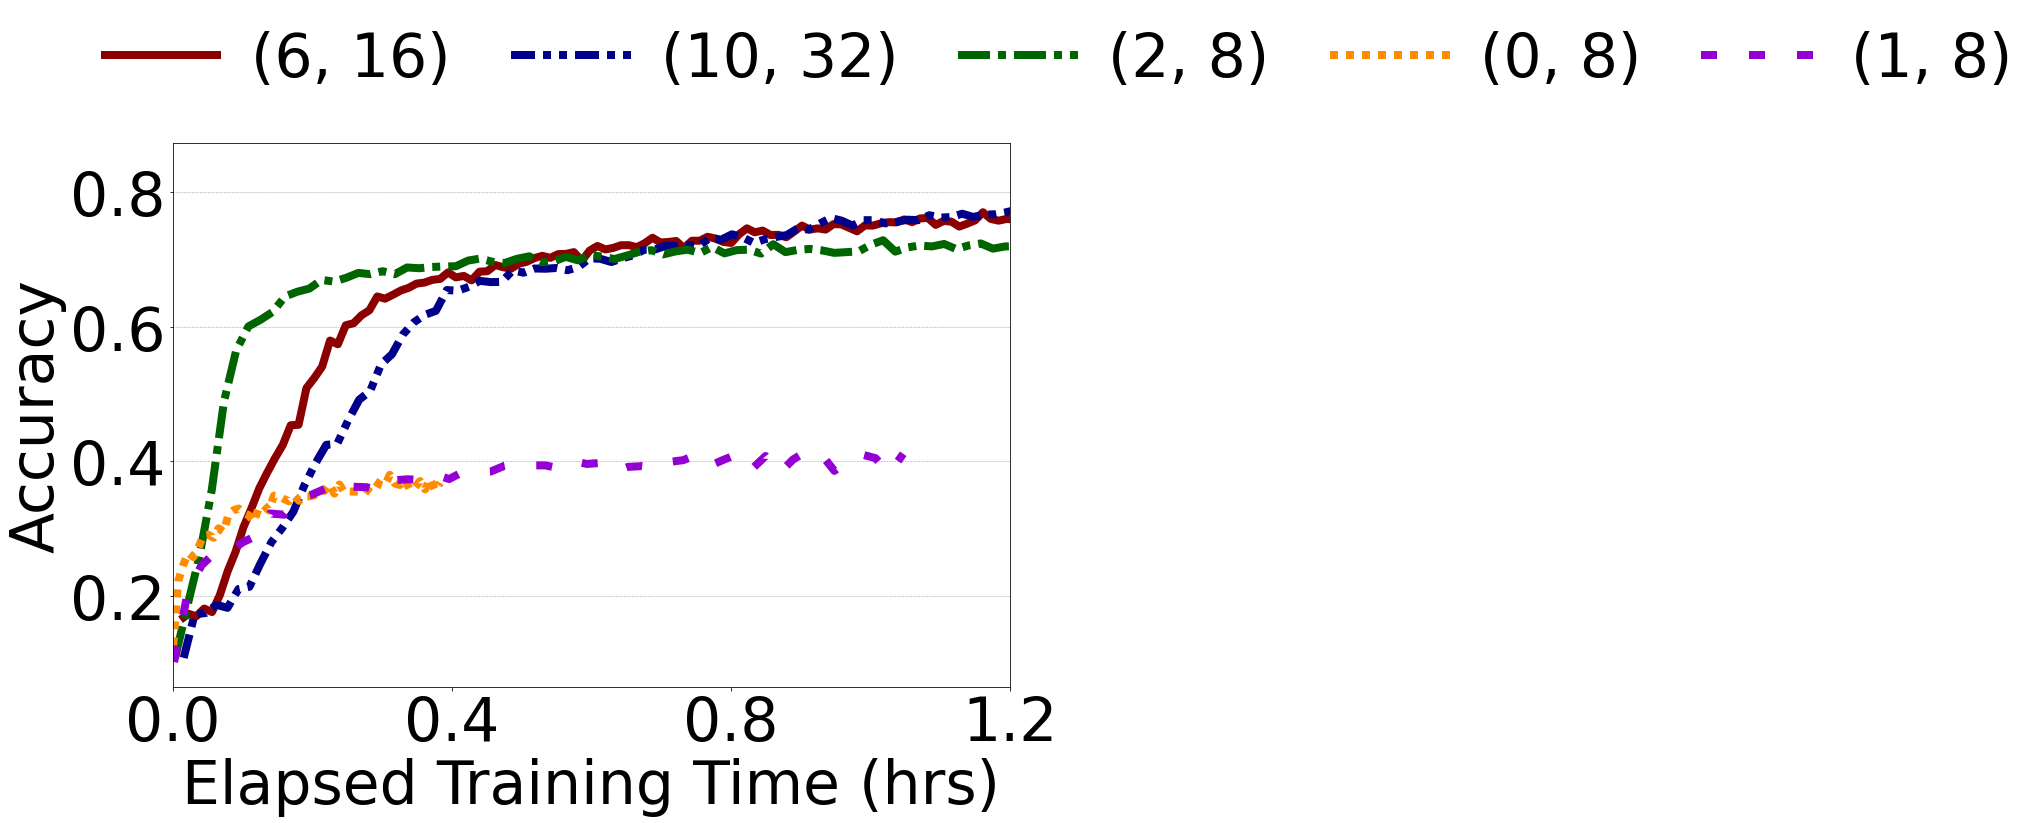

In [95]:
# variable adapter figuration
heterogenous = 0
straggler = 0
max_acc = 0.8
target_acc = 1
max_acc = max_acc * target_acc

plt.figure(figsize=(15,10))
# plt.title("Text Classification (semeval)",fontsize=60)
# 设置刻度字体大小
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.xlabel("Elapsed Training Time (hrs)", fontsize=60)
plt.ylabel("Accuracy", fontsize=60)
plt.xlim(0,1.2)
plt.grid(color = 'k', axis="y", linestyle = '--', linewidth = 0.5, alpha=0.4)

x_major_locator=MultipleLocator(0.4)
y_major_locator=MultipleLocator(0.2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

depth = np.array(range(0,13))
width = np.array([8,32,64,96,128,192])
method = np.array(["depth-0", "depth-1", "depth-2", "depth-3", "depth-4", "depth-5", "depth-6", "depth-7", "depth-8", "depth-9", "depth-10", "depth-11", "depth-12"])

model_size_8 = np.array([0.02 + i*0.01 for i in range(0,13)]) * 4
model_size_32 = np.array([0.02 + i*0.05 for i in range(0,13)]) * 4
model_size_96 = np.array([0.02 + i*0.15 for i in range(0,13)]) * 4
model_size_192 = np.array([0.02 + i*0.30 for i in range(0,13)]) * 4

# Width = 48
# model_size = np.array([0.02, 0.07, 0.12, 0.17, 0.22, 59.2, 30.8, 2.4,
#                 1.8, 1.8, 1.52, 1.2, 0.92, 0.64, 0.32, 0.04]) 

latency_tx2 = np.array([0.57, 0.57, 0.63, 0.66, 0.71, 0.75, 0.79, 0.84, 0.89, 0.94, 0.99, 1.03, 1.08]) / 4

# latency_rpi = np.array([18.27, 17.03, 15.03, 13.12, 11.83, 9.63, 8.02, 5.28,
#                 12.01, 11.65, 10.78, 9.87, 8.76, 7.85, 6.98, 7.05])

latency_tx2_cached = np.array([0.02, 0.09, 0.18, 0.27, 0.36, 0.45, 0.54, 0.63, 0.72, 0.81, 0.90, 0.99, 1.08]) / 4
# latency_rpi_cached = np.array([18.27, 16.28, 14.2, 10.89, 8.04, 5.7, 2.88, 0.14,
#                         11.25, 10.94, 9.92, 7.9, 5.96, 4.27, 2.14, 0.15])

l = latency_tx2_cached
bw = 1 # both for upload and download bandwidth
batch_num = 20 # per round
multiple = 10
# overhead per round
comm = model_size_32 * 2 / bw
comp = latency_tx2_cached * batch_num




data_path = "/Users/cdq/Desktop/opensource/FedFinetuning/data/Baseline/semeval.csv"
# data_path = "/Users/cdq/Desktop/EuroSys23 files/Temp_Code/results/20news_bert_w_16.csv"
raw_data = pd.read_csv(data_path,index_col=0)
column_name = raw_data.columns.values
i = 0
for col in column_name:

   
    multiple = 10
    w = int(col.split("-")[3])
    # w = 32
    adapter_para = 0.0125 * w / 8
    model_size = np.array([0.02 + i * adapter_para for i in range(0,13)]) * 4
    comm = model_size * 2 / bw

    time = []
    d = int(col.split("-")[1])

    if d == 10 and w == 8:
        w = 32
        pass
    elif d == 6 and w == 16:
        pass
    elif d == 2 and w == 8:
        pass
    elif d == 0 and w == 8:
        pass
    elif d == 1 and w == 8:
        pass
    else:
        continue

    data = raw_data.iloc[:,column_name.tolist().index(col)].dropna()
    round_idx = np.array(list(range(0,len(data)))) * multiple
    tmp = -1 * multiple # 记录最后一个访问的idx
    for idx in round_idx:
        time = sum_duration_cached(d, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
        tmp = idx
    if i == 2:
        time = down_sample(time)
        data = down_sample(data)
    if i >= 3:
        data = data.tolist()
        # time = time.tolist()
        time = down_sample(time,10)
        data = down_sample(data,10)
    # time, data = cut(time, data, 0.64)
    plt.plot(np.array(time)/3600, data, label = "(" + str(d) + ", " + str(w) + ")",linewidth = lw,linestyle = linestyle[i],color=color[i])
    print(col,time[-1] / 3600)
    i = i + 1 

plt.legend(fontsize=60,ncol = 5,frameon=False,loc="lower left", bbox_to_anchor=(-0.15, 1),columnspacing = 1.0,handletextpad=0.5)
plt.savefig('../figs/design-configuration-semeval.pdf', bbox_inches="tight")